In [ ]:
!gdown 1dWfWzaISPR1Cv4tR0EtNhD1jQODV0Kp9 # train test key
!gdown 1lfR4m7H2M5tpoLtLk-sLCOlMgPFRmkyY # full dataset
!gdown 1bIiROVpdUmX9af-La19asq3UXoNlR3-S # util

Downloading...
From: https://drive.google.com/uc?id=1dWfWzaISPR1Cv4tR0EtNhD1jQODV0Kp9
To: /content/train_test_key.csv
100% 7.86k/7.86k [00:00<00:00, 13.6MB/s]
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1lfR4m7H2M5tpoLtLk-sLCOlMgPFRmkyY 

Downloading...
From: https://drive.google.com/uc?id=1bIiROVpdUmX9af-La19asq3UXoNlR3-S
To: /content/util.py
100% 4.44k/4.44k [00:00<00:00, 7.04MB/s]


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from util import *
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
import tensorflow as tf
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor


import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import sklearn.linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import sklearn.impute as im
from sklearn.preprocessing import PolynomialFeatures

from datetime import timedelta
from datetime import datetime
from tqdm import tqdm

from sklearn import preprocessing


# Data processing

## train/test keys

In [ ]:
ttkey=pd.read_csv('train_test_key.csv',dtype=str)
trkey=ttkey.iloc[:,0]
trkey=[int(i) for i in list(trkey.to_numpy())]
tekey=ttkey.iloc[:,2].dropna(axis=0)
tekey=[int(i) for i in list(tekey.to_numpy())]
len(trkey),len(tekey)

(360, 90)

## subsetting dataset

In [ ]:
df=pd.read_csv('USDM_SMAP_SET_NOAA_STL_full.csv')
df[df==-9999]=np.nan
df['MapDate']=pd.to_datetime(df['MapDate'])

# Threshold
df['Y']=np.where(df['None']==100,0,1)
df

,Unnamed: 0,MapDate,FIPS,County,State,None,D0,D1,D2,D3,...,TMAX,TMIN,NDVI_1,NDVI_2,NDVI_diff,NDRE_1,NDRE_2,NDRE_diff,Region,Y
0,1593,2011-12-27,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.00,...,164.000000,55.500000,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,1
1,1594,2012-01-03,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.00,...,170.000000,40.571429,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,1
2,1595,2012-01-10,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.00,...,148.428571,25.428571,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,1
3,1596,2012-01-17,1007,Bibb County,AL,41.41,58.59,0.00,0.0,0.00,...,196.142857,95.428571,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,1
4,1597,2012-01-24,1007,Bibb County,AL,100.00,0.00,0.00,0.0,0.00,...,193.571429,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,Southeast,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238945,1649812,2022-01-25,56043,Washakie County,WY,0.00,100.00,100.00,100.0,0.00,...,36.428571,-135.857143,59.769846,63.385346,-5.704000,80.070830,85.601462,-6.460908,NorthernRR,1
238946,1649813,2022-02-01,56043,Washakie County,WY,0.00,100.00,100.00,100.0,0.00,...,-0.714286,-153.285714,63.385346,58.522920,8.308584,85.601462,94.392398,-9.313183,NorthernRR,1
238947,1649814,2022-02-08,56043,Washakie County,WY,0.00,100.00,100.00,100.0,16.75,...,76.857143,-88.000000,58.522920,48.684130,20.209440,94.392398,96.972405,-2.660558,NorthernRR,1
238948,1649815,2022-02-15,56043,Washakie County,WY,0.00,100.00,100.00,100.0,52.39,...,77.000000,-88.142857,48.684130,40.099745,21.407581,96.972405,93.996836,3.165605,NorthernRR,1


In [ ]:
cache=df[['MapDate', 'FIPS STR', 'Y', 'roff', 'evap','Region']]#, 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']]
cache=cache.rename(columns={'FIPS STR':'FIPS_STR'})
dfs=cache.dropna()

dfs['dT']=[np.timedelta64(dfs['MapDate'].to_numpy()[i]-dfs['MapDate'].to_numpy()[0],'W').astype(int) for i in range(dfs.shape[0])]
dfs

,MapDate,FIPS_STR,Y,roff,evap,Region,dT
157,2014-12-30,1007,0,0.001730,-3.701072e-04,Southeast,0
158,2015-01-06,1007,0,0.000068,-9.940644e-05,Southeast,1
159,2015-01-13,1007,0,0.000077,-1.348449e-04,Southeast,2
160,2015-01-20,1007,0,0.000395,-3.874424e-04,Southeast,3
161,2015-01-27,1007,0,0.000193,-2.163508e-04,Southeast,4
...,...,...,...,...,...,...,...
238937,2021-11-30,56043,1,0.000002,-2.076237e-05,NorthernRR,361
238938,2021-12-07,56043,1,0.000002,-8.488739e-06,NorthernRR,362
238939,2021-12-14,56043,1,0.000002,-5.072568e-05,NorthernRR,363
238940,2021-12-21,56043,1,0.000002,-2.681730e-05,NorthernRR,364


In [ ]:
dfs.columns.tolist()

['MapDate', 'FIPS_STR', 'Y', 'roff', 'evap', 'Region', 'dT']

## onehot encoding

In [ ]:
if 'Region' in dfs.columns.tolist():
  print('yes')
  onehot = pd.get_dummies(dfs.Region, prefix='Region')
  onehot.head()
  onehot.columns
  dfs = pd.concat([dfs, onehot], axis=1)
  dfs

yes


In [ ]:
x = dfs[['roff', 'evap']]#, 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']]

scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)

dfs[['roff', 'evap']] = x_scaled
dfs

,MapDate,FIPS_STR,Y,roff,evap,Region,dT,Region_Northeast,Region_NorthernRR,Region_Northwest,Region_OhioValley,Region_South,Region_Southeast,Region_Southwest,Region_UpperMidwest,Region_West
157,2014-12-30,1007,0,1.489437,-0.290665,Southeast,0,0,0,0,0,0,1,0,0,0
158,2015-01-06,1007,0,-0.401719,0.700426,Southeast,1,0,0,0,0,0,1,0,0,0
159,2015-01-13,1007,0,-0.391351,0.570678,Southeast,2,0,0,0,0,0,1,0,0,0
160,2015-01-20,1007,0,-0.029851,-0.354133,Southeast,3,0,0,0,0,0,1,0,0,0
161,2015-01-27,1007,0,-0.260435,0.272269,Southeast,4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238937,2021-11-30,56043,1,-0.476740,0.988358,NorthernRR,361,0,1,0,0,0,0,0,0,0
238938,2021-12-07,56043,1,-0.477201,1.033294,NorthernRR,362,0,1,0,0,0,0,0,0,0
238939,2021-12-14,56043,1,-0.476740,0.878656,NorthernRR,363,0,1,0,0,0,0,0,0,0
238940,2021-12-21,56043,1,-0.476774,0.966189,NorthernRR,364,0,1,0,0,0,0,0,0,0


Check Y variable's balence of classes

In [ ]:
yy=dfs.Y.to_numpy()
np.sum(yy)/len(yy)

0.4983630898049095

WARNING: county 45019 is NaN. We exclude this county and lose 366 weeks of information because of this. The loss is acceptable. We continue.

In [ ]:
dfs_fips=dfs['FIPS_STR'].unique()
for i in trkey:
  if i in dfs_fips: pass
  else: print(i)

45019


In [ ]:
df[df['FIPS STR']==45019].roff

185850   NaN
185851   NaN
185852   NaN
185853   NaN
185854   NaN
          ..
186376   NaN
186377   NaN
186378   NaN
186379   NaN
186380   NaN
Name: roff, Length: 531, dtype: float64

# Model Training
TRAIN ON TRAINING SET'S WEEK 0   TO 285

TEST  ON TESTING SET'S  WEEK 286 TO 365

286 out of 366 is roughly 80/20 train test split

In [ ]:
# Here, we double check time keys are correctly assigned

print('train')
print(timekey(horizon=26, nhist=26,thin=False,total_days=286,test=False)[:5])
print('test:')
print(timekey(horizon=26, nhist=26,thin=False,total_days=286,test=True)[:5])

train
[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25]), array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51])), (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26]), array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52])), (array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27]), array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53])), (array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28]), array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54])), (array([ 4,  5,  6,  7,  

In [ ]:
gen=True
horizon_=26
nhist_=52
feature_name=['Y','roff', 'evap',
              'Region_Northeast', 'Region_NorthernRR', 'Region_Northwest',
              'Region_OhioValley', 'Region_South', 'Region_Southeast',
              'Region_Southwest', 'Region_UpperMidwest', 'Region_West']

              #,  'NDVI_diff',  'NDRE_diff']
              # 'PRCP', 'SNWD','TMAX', 'TMIN',
thin=False
  
if gen==True:

  tkey=timekey(horizon=horizon_, nhist=nhist_,thin=thin,total_days=208,test=False)
  # print(tkey[:4])
  label_key=np.array(tkey)[:,1]
  feature_key=np.array(tkey)[:,0]

  shape_=len(feature_name)*nhist_

  x_tr,y_tr=[],[]
  for i in tqdm(trkey):
    cache=dfs[dfs['FIPS_STR']==i]
    if cache.shape[0]==0: 
      print('passed county:', i)
      pass
    else:
      for j in np.arange(1,len(label_key)):
        feature=cache[cache['dT'].isin(feature_key[j])][feature_name].to_numpy()
        label=cache[cache['dT'].isin(label_key[j])]['Y'].to_numpy()
        # print(feature,label)
        # break
        
        x_tr.append(feature)
        y_tr.append(label)


  x_te,y_te=[],[]
  for i in tqdm(tekey):
    cache=dfs[dfs['FIPS_STR']==i]
    if cache.shape[0]==0: 
      print('passed county:', i)
      pass
    else:
      for j in np.arange(1,len(label_key)):
        feature=cache[cache['dT'].isin(feature_key[j])][feature_name].to_numpy()
        label=cache[cache['dT'].isin(label_key[j])]['Y'].to_numpy()
        
        x_te.append(feature)
        y_te.append(label)

  x_tr_np=np.array(x_tr)
  y_tr_np=np.array(y_tr)

  x_te_np=np.array(x_te)
  y_te_np=np.array(y_te)


  # from google.colab import drive
  # drive.mount('/content/drive')
  # np.savez('drive/MyDrive/HWs/data',np.array([x_tr_np,y_tr_np,x_te_np,y_te_np]))
  
else:
  !gdown 1-3Abm7XSbcnVaV138um4UrTOQv6lV8pU
  npzfile = np.load('data.npz',allow_pickle=True)
  x_tr_np,y_tr_np,x_te_np,y_te_np=npzfile['arr_0'][0],npzfile['arr_0'][1],npzfile['arr_0'][2],npzfile['arr_0'][3]

 40%|████      | 145/360 [00:37<00:56,  3.83it/s]

passed county: 45019


100%|██████████| 90/90 [00:23<00:00,  3.86it/s]


In [ ]:
x_tr_np.shape, x_te_np.shape

((46670, 52, 12), (11700, 52, 12))

Text(0.5, 0.98, 'Visualization of feature input')

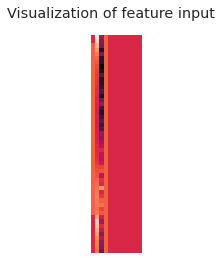

In [ ]:
plt.imshow(x_tr_np[16])
plt.axis('off')
plt.suptitle('Visualization of feature input')

## LSTM-CNN DroughtNet

In [ ]:
lstm_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 52, 12)]          0         
                                                                 
 lstm_36 (LSTM)              (None, 52, 128)           72192     
                                                                 
 reshape_12 (Reshape)        (None, 52, 128, 1)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 52, 128, 64)       1664      
                                                                 
 conv2d_30 (Conv2D)          (None, 52, 128, 32)       18464     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 64, 32)       0         
 g2D)                                                            
                                                          

In [ ]:
# LSTM-CNN model

inputs = Input(shape = (52,12),name='lstm_input')
lstm_layer = LSTM(128,return_sequences=True, activation='relu')(inputs) 
  # return h(t) at each of the 52 time steps
  # we then treat the 52x128 embedding as an image, and get CNN embeddings
reshape_layer = Reshape((52, 128,1))(lstm_layer)
top_cnn = Conv2D(64, (5, 5),padding='same', activation='relu')(reshape_layer)
top_cnn = Conv2D(32, (3, 3),padding='same', activation='relu')(top_cnn)
top_cnn = MaxPooling2D()(top_cnn)
top_cnn = Dropout(0.2)(top_cnn)
top_cnn = Flatten()(top_cnn)

# dense classification layers for short term task
class_layer = (Dense(128, kernel_initializer='normal',activation='relu'))(top_cnn)
class_layer = (BatchNormalization())(class_layer)
class_layer = (Dropout(0.2))(class_layer)
class_layer = (Dense(128, kernel_initializer='normal',activation='relu'))(class_layer)
class_layer = (BatchNormalization())(class_layer)
class_layer = (Dropout(0.2))(class_layer)
class_layer = (Dense(26,activation='sigmoid'))(class_layer)

lstm_model = tf.keras.models.Model(inputs = inputs,outputs = class_layer)

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= tf.metrics.BinaryAccuracy())

hist = lstm_model.fit(x_tr_np,y_tr_np,
                 validation_split=0.1,
                 batch_size=64,
                 epochs=20,
                 verbose=1)

Epoch 1/20
657/657 [==============================] - 123s 181ms/step - loss: 0.5195 - binary_accuracy: 0.7435 - val_loss: 0.4848 - val_binary_accuracy: 0.7669
Epoch 2/20
657/657 [==============================] - 117s 178ms/step - loss: 0.4096 - binary_accuracy: 0.8125 - val_loss: 0.4800 - val_binary_accuracy: 0.7801
Epoch 3/20
657/657 [==============================] - 116s 177ms/step - loss: 0.3432 - binary_accuracy: 0.8480 - val_loss: 0.4981 - val_binary_accuracy: 0.7831
Epoch 4/20
657/657 [==============================] - 117s 178ms/step - loss: 0.2933 - binary_accuracy: 0.8725 - val_loss: 0.5366 - val_binary_accuracy: 0.7820
Epoch 5/20
657/657 [==============================] - 116s 177ms/step - loss: 0.2529 - binary_accuracy: 0.8916 - val_loss: 0.5386 - val_binary_accuracy: 0.7846
Epoch 6/20
657/657 [==============================] - 115s 176ms/step - loss: 0.2226 - binary_accuracy: 0.9059 - val_loss: 0.5655 - val_binary_accuracy: 0.7944
Epoch 7/20
657/657 [====================

In [ ]:
print('test accuracy:')
lstm_model.evaluate(x_te_np,y_te_np)

test accuracy:
366/366 [==============================] - 11s 29ms/step - loss: 0.7128 - binary_accuracy: 0.8035


[0.7127854824066162, 0.803451418876648]

In [ ]:
x_te_pred_proba=lstm_model.predict(x_te_np)
x_te_pred=np.where(x_te_pred_proba>0.5,1,0)



In [ ]:
from sklearn.metrics import accuracy_score as acc

for i in range(26): print('future week: ', i+1,', accuracy: ',acc(y_te_np[:,i],x_te_pred.astype(float)[:,i]))

future week:  1 , accuracy:  0.9161538461538462
future week:  2 , accuracy:  0.8894017094017094
future week:  3 , accuracy:  0.8636752136752137
future week:  4 , accuracy:  0.8422222222222222
future week:  5 , accuracy:  0.8275213675213675
future week:  6 , accuracy:  0.8135042735042735
future week:  7 , accuracy:  0.8052991452991453
future week:  8 , accuracy:  0.801965811965812
future week:  9 , accuracy:  0.8015384615384615
future week:  10 , accuracy:  0.7986324786324787
future week:  11 , accuracy:  0.7917948717948718
future week:  12 , accuracy:  0.7873504273504274
future week:  13 , accuracy:  0.7874358974358975
future week:  14 , accuracy:  0.785042735042735
future week:  15 , accuracy:  0.7829059829059829
future week:  16 , accuracy:  0.7835897435897435
future week:  17 , accuracy:  0.7831623931623931
future week:  18 , accuracy:  0.7835042735042735
future week:  19 , accuracy:  0.7832478632478632
future week:  20 , accuracy:  0.7833333333333333
future week:  21 , accuracy:  0

In [ ]:
from sklearn.metrics import roc_auc_score as auc

for i in range(26): print('future week: ', i+1,', auc: ',auc(y_te_np[:,i],x_te_pred_proba[:,i]))


future week:  1 , auc:  0.9680690374025501
future week:  2 , auc:  0.9509475023617053
future week:  3 , auc:  0.9337904767063402
future week:  4 , auc:  0.917003983805964
future week:  5 , auc:  0.9024211168575265
future week:  6 , auc:  0.8903230006456709
future week:  7 , auc:  0.8827569256499066
future week:  8 , auc:  0.8773315608025848
future week:  9 , auc:  0.875242354043889
future week:  10 , auc:  0.8712041252953091
future week:  11 , auc:  0.8677459642660661
future week:  12 , auc:  0.8628262809964479
future week:  13 , auc:  0.8620939886364549
future week:  14 , auc:  0.8595627137688324
future week:  15 , auc:  0.8577194507622202
future week:  16 , auc:  0.8565419850648931
future week:  17 , auc:  0.8549105054579882
future week:  18 , auc:  0.8548675402365377
future week:  19 , auc:  0.8523797739498137
future week:  20 , auc:  0.8527563156958042
future week:  21 , auc:  0.8534235409247087
future week:  22 , auc:  0.8547275367085431
future week:  23 , auc:  0.8553603291542508

## CNN multitasking DroughtNet

In [ ]:
feature_name

['Y',
 'roff',
 'evap',
 'Region_Northeast',
 'Region_NorthernRR',
 'Region_Northwest',
 'Region_OhioValley',
 'Region_South',
 'Region_Southeast',
 'Region_Southwest',
 'Region_UpperMidwest',
 'Region_West']

In [ ]:
# input and conv layers

inputs = Input(shape = (nhist_,len(feature_name),1),name='main_input')
top_cnn = Conv2D(64, (4, 2),padding='same', activation='relu')(inputs)
top_cnn = MaxPooling2D()(top_cnn)
top_cnn = Dropout(0.2)(top_cnn)
top_cnn = Conv2D(32, (16, 2),padding='same', activation='relu')(top_cnn)
top_cnn = MaxPooling2D()(top_cnn)
top_cnn = Dropout(0.2)(top_cnn)
top_cnn = Flatten()(top_cnn)

# dense classification layers for short term task
short_term = (Dense(64, kernel_initializer='normal',activation='relu'))(top_cnn)
short_term = (BatchNormalization())(short_term)
short_term = (Dropout(0.2))(short_term)
short_term = (Dense(32, kernel_initializer='normal',activation='relu'))(short_term)
short_term = (BatchNormalization())(short_term)
short_term = (Dropout(0.2))(short_term)
short_term = (Dense(4,activation='sigmoid',name='short_term'))(short_term)

# dense classification layers for long term task
long_term = Dense(512, kernel_initializer='normal',activation='relu')(top_cnn)
long_term = (BatchNormalization())(long_term)
long_term = (Dropout(0.2))(long_term)
long_term = Dense(256, kernel_initializer='normal',activation='relu')(long_term)
long_term = (BatchNormalization())(long_term)
long_term = (Dropout(0.2))(long_term)
long_term = Dense(128, kernel_initializer='normal',activation='relu')(long_term)
long_term = (BatchNormalization())(long_term)
long_term = (Dropout(0.2))(long_term)
long_term = (Dense(64, kernel_initializer='normal',activation='relu'))(long_term)
long_term = (Dropout(0.2))(long_term)
long_term = (Dense(horizon_-4,activation='sigmoid',name='long_term'))(long_term)



In [ ]:
model = tf.keras.models.Model(inputs = inputs,outputs = [short_term,long_term])

In [ ]:
model = tf.keras.models.Model(inputs = inputs,outputs = [short_term,long_term])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss={'short_term':tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    'long_term': tf.keras.losses.BinaryCrossentropy(from_logits=True)},
              loss_weights={'short_term':0.50, 
                            'long_term':0.50},
              metrics={'short_term':tf.metrics.BinaryAccuracy(), 
                       'long_term':tf.metrics.BinaryAccuracy()})

hist = model.fit({'main_input': x_tr_np},
                 {'short_term': y_tr_np[:,:4], 
                  'long_term':y_tr_np[:,4:]},
                 validation_split=0.1,
                 batch_size=64,
                 epochs=200,
                 verbose=1)

Epoch 1/200
657/657 [==============================] - 22s 21ms/step - loss: 0.3267 - short_term_loss: 0.2757 - long_term_loss: 0.3776 - short_term_binary_accuracy: 0.8909 - long_term_binary_accuracy: 0.8292 - val_loss: 0.3967 - val_short_term_loss: 0.3110 - val_long_term_loss: 0.4824 - val_short_term_binary_accuracy: 0.8752 - val_long_term_binary_accuracy: 0.7769
Epoch 2/200
657/657 [==============================] - 14s 21ms/step - loss: 0.3241 - short_term_loss: 0.2757 - long_term_loss: 0.3725 - short_term_binary_accuracy: 0.8903 - long_term_binary_accuracy: 0.8322 - val_loss: 0.4017 - val_short_term_loss: 0.3152 - val_long_term_loss: 0.4882 - val_short_term_binary_accuracy: 0.8709 - val_long_term_binary_accuracy: 0.7735
Epoch 3/200
657/657 [==============================] - 14s 21ms/step - loss: 0.3187 - short_term_loss: 0.2713 - long_term_loss: 0.3661 - short_term_binary_accuracy: 0.8916 - long_term_binary_accuracy: 0.8350 - val_loss: 0.3918 - val_short_term_loss: 0.3078 - val_lon

In [ ]:
#tf.keras.utils.plot_model(model, show_layer_activations=True,show_shapes=True)

In [ ]:
x_tr_np.shape, x_te_np.shape

((46670, 52, 12), (11700, 52, 12))

In [ ]:
print('test accuracy:')
model.evaluate({'main_input': x_te_np},{'short_term': y_te_np[:,:4], 'long_term':y_te_np[:,4:]})[-2:]

test accuracy:
366/366 [==============================] - 3s 7ms/step - loss: 0.4665 - short_term_loss: 0.3248 - long_term_loss: 0.6082 - short_term_binary_accuracy: 0.8890 - long_term_binary_accuracy: 0.8138


[0.8890384435653687, 0.8137840628623962]

In [ ]:
x_te_pred_proba=model.predict(x_te_np)
#x_te_pred=np.where(x_te_pred_proba>0.5,1,0)
x_te_pred=x_te_pred_proba.copy()
for i in range(2): x_te_pred[i]=np.where(x_te_pred[i]>0.5,1,0)

In [ ]:
from sklearn.metrics import accuracy_score as acc

for i in range(4): print('future week: ', i+1,', accuracy: ',acc(y_te_np[:,i],x_te_pred[0][:,i]))
for i in range(horizon_-4): print('future week: ', i+4+1,', accuracy: ',acc(y_te_np[:,4+i],x_te_pred[1][:,i]))

future week:  1 , accuracy:  0.9354700854700855
future week:  2 , accuracy:  0.8992307692307693
future week:  3 , accuracy:  0.8698290598290598
future week:  4 , accuracy:  0.8516239316239316
future week:  5 , accuracy:  0.8430769230769231
future week:  6 , accuracy:  0.8430769230769231
future week:  7 , accuracy:  0.8357264957264957
future week:  8 , accuracy:  0.8316239316239317
future week:  9 , accuracy:  0.8252991452991453
future week:  10 , accuracy:  0.8211965811965812
future week:  11 , accuracy:  0.8161538461538461
future week:  12 , accuracy:  0.8135042735042735
future week:  13 , accuracy:  0.8094017094017094
future week:  14 , accuracy:  0.8048717948717948
future week:  15 , accuracy:  0.8047008547008547
future week:  16 , accuracy:  0.804017094017094
future week:  17 , accuracy:  0.8038461538461539
future week:  18 , accuracy:  0.8046153846153846
future week:  19 , accuracy:  0.8041025641025641
future week:  20 , accuracy:  0.8023931623931624
future week:  21 , accuracy:  

In [ ]:
from sklearn.metrics import roc_auc_score as auc

for i in range(4): print('future week: ', i+1,', auc: ',auc(y_te_np[:,i],x_te_pred_proba[0][:,i]))
for i in range(horizon_-4): print('future week: ', i+4+1,', auc: ',auc(y_te_np[:,4+i],x_te_pred_proba[1][:,i]))

future week:  1 , auc:  0.9747865888848878
future week:  2 , auc:  0.9576519342296712
future week:  3 , auc:  0.9406397574454699
future week:  4 , auc:  0.9242211376264478
future week:  5 , auc:  0.9203723223626483
future week:  6 , auc:  0.9163266898258563
future week:  7 , auc:  0.9093823846024112
future week:  8 , auc:  0.9019642167306612
future week:  9 , auc:  0.8970456527476856
future week:  10 , auc:  0.8931362390627984
future week:  11 , auc:  0.8899478819203542
future week:  12 , auc:  0.8868399248796912
future week:  13 , auc:  0.883890504722384
future week:  14 , auc:  0.8817557587702305
future week:  15 , auc:  0.8805365905341067
future week:  16 , auc:  0.8795268074282389
future week:  17 , auc:  0.8791922061583397
future week:  18 , auc:  0.8788702506278729
future week:  19 , auc:  0.8790363186114188
future week:  20 , auc:  0.8785923540082434
future week:  21 , auc:  0.8783799521480303
future week:  22 , auc:  0.8787380046127131
future week:  23 , auc:  0.880701205557095